Sampled Points: [[-1.65227304  0.49539903]
 [ 0.25175635 -0.19633719]
 [-0.0363181  -0.88853583]
 [-2.2109064   0.65897361]
 [ 2.96022902 -0.41778333]
 [-0.2594071  -0.11187214]
 [ 1.29133895  0.71789979]
 [ 0.41419503 -1.41216384]
 [ 0.36629146  2.28222638]
 [-0.17475352 -0.35488562]
 [-0.43882692  0.22638516]
 [ 0.94782911 -1.24702225]
 [-0.96745739 -1.15365784]
 [-0.14153779 -0.46528308]
 [-0.63711779 -1.14571813]
 [-1.00610193  1.11067471]
 [-1.33545019 -0.73381175]
 [-0.8537628   0.96065573]
 [-0.86819729 -0.73858592]
 [-1.25547614 -0.84223093]]
Weights: [0.00346987 0.00076822 0.0025775  0.05379682 0.00626367 0.00734032
 0.01188349 0.01670179 0.21053307 0.01334434 0.02548871 0.06770924
 0.03131333 0.04363157 0.10605266 0.04047595 0.0265021  0.02796212
 0.02912554 0.27505968]


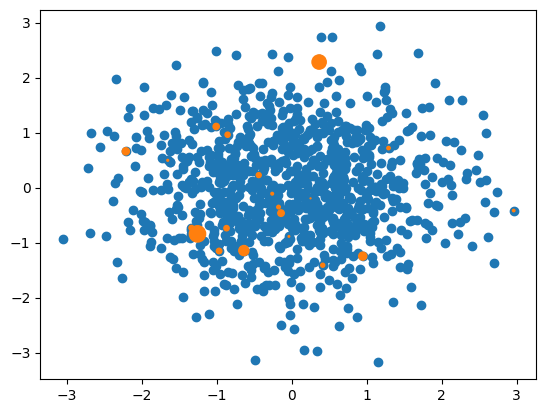

In [78]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import ortho_group

def generate_rff_matrix(X, tau, num_features):
    n, d = X.shape
    
    # Generate random Fourier vectors
    # omega = np.random.normal(size=(d, num_features)) / np.sqrt(tau)
    #use laplace distribution
    omega = np.random.laplace(size=(d, num_features)) / np.sqrt(tau)
    b = 2 * np.pi * np.random.rand(num_features)
    cos_component = np.cos(X @ omega + b)  # (n, num_features)
    sin_component = np.sin(X @ omega + b)  # (n, num_features)
    
    # Combine cos and sin components into the RFF matrix
    rff_matrix = np.empty((2*num_features, n))
    rff_matrix[:num_features, :] = cos_component.T
    rff_matrix[num_features:, :] = sin_component.T
    return rff_matrix



def compute_dpp_sample(rff_matrix, num_samples):
    # Compute the Gram matrix ΨΨ^T
    gram_matrix = rff_matrix @ rff_matrix.T
    
    # Perform eigendecomposition of the Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix)
    # Keep only positive eigenvalues and corresponding eigenvectors
    positive_indices = eigenvalues > 0
    positive_eigenvalues = eigenvalues[positive_indices]
    positive_eigenvectors = eigenvectors[:, positive_indices]

    # Normalize eigenvectors
    normalized_eigenvectors=[]
    for eigen_vector in positive_eigenvectors.T:
        eigen_vector1 = eigen_vector/np.linalg.norm(eigen_vector)
        normalized_eigenvectors.append(eigen_vector1)
    normalized_eigenvectors = np.array(normalized_eigenvectors).T
    # Sample indices according to the DPP distribution
    num_samples = min(num_samples, len(positive_eigenvalues))
    sampled_indices = np.random.choice(len(positive_eigenvalues), num_samples, replace=False, p=positive_eigenvalues/np.sum(positive_eigenvalues))
    probability = positive_eigenvalues/np.sum(positive_eigenvalues)
    # print(probability[sampled_indices])
    weights=1/probability[sampled_indices]
    weights=weights/np.sum(weights)
    return sampled_indices,weights

    

def dpp_coreset(X, tau, num_samples):
    r = 2*num_samples # Choose r as a function of m (number of samples)
    rff_matrix = generate_rff_matrix(X, tau, r)
    
    sampled_indices,weights = compute_dpp_sample(rff_matrix, num_samples)
    # print(sampled_indices)
    return X[sampled_indices], weights,sampled_indices

# Example usage:
# Assuming X is your dataset (n x d numpy array), tau is the Gaussian kernel parameter, and m is the number of samples
X = np.random.randn(1000, 2)  # Example dataset
tau = 1.5
m = 20
sampled_points, weights,_ = dpp_coreset(X, tau, m)
print("Sampled Points:", sampled_points)
print("Weights:", weights)

#plot the sampled points
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],label='Original Data')
#point shoould be bigger if it has more weight
plt.scatter(sampled_points[:,0],sampled_points[:,1],label='Sampled Points',s=weights*500)
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

torch.manual_seed(0)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
#     for epoch in range(num_epochs):
#         model.train()
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
        
#         model.eval()
#         val_correct = 0
#         val_total = 0
#         for inputs, labels in val_loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             val_correct += (predicted == labels).sum().item()
#             val_total += labels.size(0)
        
#         val_accuracy = val_correct / val_total
#         print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy:.4f}")

def train_model(model, train_loader, weights, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) * weights[i]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
def train_model_weigths(model, train_loader, criterion, optimizer,weight,len, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)*weight
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        
def train_model2(model, train_loader, criterion, optimizer, num_epochs=5):
    # Assuming `train_loader` is set up to load Fashion MNIST data
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Reshape images to [batch_size, 1, 28, 28]
            images = images.view(-1, 1, 28, 28)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [9]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
print(len(train_data))

48000


In [10]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
# Extract a subset of data_points from the Fashion MNIST dataset
data_points = []
for images, labels in train_loader:
    flattened_images = images.view(images.size(0), -1).numpy()
    data_points.extend(flattened_images)

data_points = np.array(data_points)  # Convert to numpy array
print(data_points.shape)

(48000, 784)


In [69]:
sampled_points, weights,indices= dpp_coreset(data_points, tau, 500)

In [70]:
indices=np.array(indices)
print(indices)

[1944  857 1647  947  867 1039 1700  533  363 1791   17 1973 1965  890
  193 1886 1217  327 1293  768   75 1988 1308 1194  439 1575  876 1716
 1742 1833 1690 1111 1854 1000 1209  608  509  601  127 1270 1717  169
  264 1113 1501 1496 1023  583  619 1780  805  125  630 1953  918  153
 1168 1365 1875   19 1264 1660  604 1321  972 1948 1943  416  599 1305
 1185  643  222 1132   74  579 1480  497 1447 1689  686 1391 1906 1841
  366 1287 1097  109 1107  692 1476  597  973  502 1254 1296  612 1711
  839 1003 1858 1463  123 1521 1954 1991 1677 1902 1744  306 1627  370
 1274  764 1257  886 1603  725 1129  586  460  555 1842 1395 1306  930
 1103   51 1190 1284  124 1593  991 1128 1812  569 1726 1653 1904  483
 1900  440 1520 1414 1724 1072  820  729  143 1910  681   59 1478 1706
  273  912 1519  230 1966 1404 1099  652 1027  144 1613 1150  871 1746
  319  900 1949 1675 1431  224 1846 1582 1482 1969  195   83  343 1806
 1927 1835 1332 1265  913  479 1958 1189 1632 1462 1436  436 1938 1155
 1898 

In [71]:
coreset_data_points=[]
for i in indices:
    coreset_data_points.append(train_data[i])

In [72]:
coreset_train_loader = DataLoader(coreset_data_points, batch_size=64, shuffle=True)

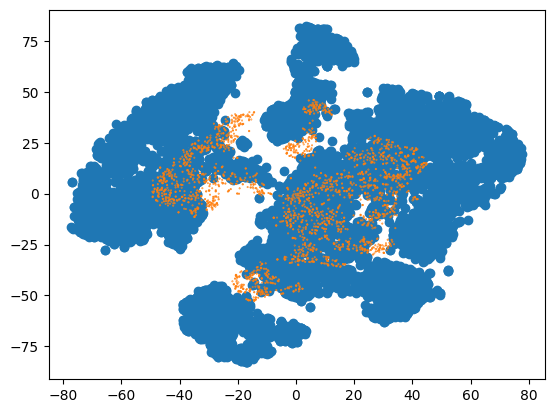

In [70]:
#convert data to 2D using tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
data_points_2d = tsne.fit_transform(data_points[:10000])
sampled_points_2d = tsne.fit_transform(sampled_points)


#plot the sampled points
import matplotlib.pyplot as plt
plt.scatter(data_points_2d[:,0],data_points_2d[:,1],label='Original Data')
#point shoould be bigger if it has more weight
plt.scatter(sampled_points_2d[:,0],sampled_points_2d[:,1],label='Sampled Points',s=weights*500)
plt.show()

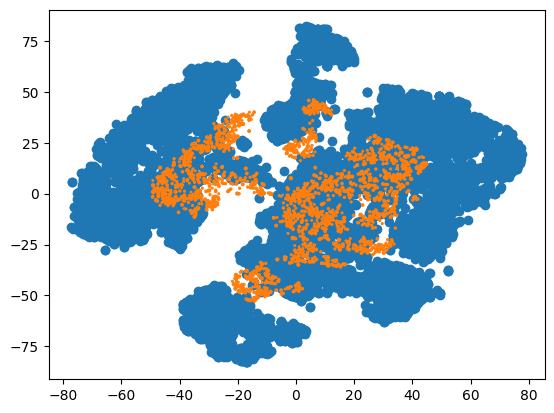

In [71]:
plt.scatter(data_points_2d[:,0],data_points_2d[:,1],label='Original Data')
#point shoould be bigger if it has more weight
plt.scatter(sampled_points_2d[:,0],sampled_points_2d[:,1],label='Sampled Points',s=weights*5000)
plt.show()

In [73]:
model_coreset = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_coreset = optim.Adam(model_coreset.parameters(), lr=0.001)

print("Training on coreset:")
train_model(model_coreset, coreset_train_loader,weights, criterion, optimizer_coreset,200)

Training on coreset:
Epoch [1/200], Loss: 0.0038
Epoch [2/200], Loss: 0.0022
Epoch [3/200], Loss: 0.0015
Epoch [4/200], Loss: 0.0013
Epoch [5/200], Loss: 0.0012
Epoch [6/200], Loss: 0.0011
Epoch [7/200], Loss: 0.0011
Epoch [8/200], Loss: 0.0009
Epoch [9/200], Loss: 0.0008
Epoch [10/200], Loss: 0.0008
Epoch [11/200], Loss: 0.0007
Epoch [12/200], Loss: 0.0006
Epoch [13/200], Loss: 0.0005
Epoch [14/200], Loss: 0.0004
Epoch [15/200], Loss: 0.0005
Epoch [16/200], Loss: 0.0004
Epoch [17/200], Loss: 0.0004
Epoch [18/200], Loss: 0.0003
Epoch [19/200], Loss: 0.0003
Epoch [20/200], Loss: 0.0002
Epoch [21/200], Loss: 0.0002
Epoch [22/200], Loss: 0.0002
Epoch [23/200], Loss: 0.0002
Epoch [24/200], Loss: 0.0002
Epoch [25/200], Loss: 0.0001
Epoch [26/200], Loss: 0.0001
Epoch [27/200], Loss: 0.0001
Epoch [28/200], Loss: 0.0001
Epoch [29/200], Loss: 0.0001
Epoch [30/200], Loss: 0.0001
Epoch [31/200], Loss: 0.0001
Epoch [32/200], Loss: 0.0001
Epoch [33/200], Loss: 0.0001
Epoch [34/200], Loss: 0.0000
Ep

In [44]:
model_full = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_coreset = optim.Adam(model_full.parameters(), lr=0.001)
weights=np.ones(len(train_loader))

print("Training on coreset:")
train_model(model_full, train_loader, weights,criterion, optimizer_coreset,10)

Training on coreset:
Epoch [1/10], Loss: 0.4791
Epoch [1/10], Loss: 0.4791
Epoch [2/10], Loss: 0.2959
Epoch [2/10], Loss: 0.2959
Epoch [3/10], Loss: 0.2463
Epoch [3/10], Loss: 0.2463
Epoch [4/10], Loss: 0.2124
Epoch [4/10], Loss: 0.2124
Epoch [5/10], Loss: 0.1861
Epoch [5/10], Loss: 0.1861
Epoch [6/10], Loss: 0.1612
Epoch [6/10], Loss: 0.1612
Epoch [7/10], Loss: 0.1422
Epoch [7/10], Loss: 0.1422
Epoch [8/10], Loss: 0.1216
Epoch [8/10], Loss: 0.1216
Epoch [9/10], Loss: 0.1039
Epoch [9/10], Loss: 0.1039
Epoch [10/10], Loss: 0.0870
Epoch [10/10], Loss: 0.0870


In [74]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy# Evaluate the model trained on the coreset
accuracy_coreset = evaluate_model(model_full, test_loader)
print(f'Accuracy on coreset: {accuracy_coreset:.2f}')

# Evaluate the model trained on the full dataset
accuracy_full = evaluate_model(model_coreset, test_loader)
print(f'Accuracy on full dataset: {accuracy_full:.2f}')


Accuracy on coreset: 0.92
Accuracy on full dataset: 0.81


In [61]:
# apply PCA to the data from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
data_points_pca = pca.fit_transform(data_points)
print(data_points_pca.shape)


(48000, 200)


In [62]:
sampled_points_pca, weights_pca,indices_pca= dpp_coreset(data_points_pca, tau, 2000)

In [63]:
coreset_data_points_pca=[]
for i in indices:
    coreset_data_points_pca.append(train_data[i])

In [64]:
cnn_coreset_loader_pca = DataLoader(coreset_data_points_pca, batch_size=64, shuffle=True)

In [65]:
model_coreset_pca = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_coreset = optim.Adam(model_coreset_pca.parameters(), lr=0.001)

print("Training on coreset:")
train_model(model_coreset_pca, cnn_coreset_loader_pca, weights_pca,criterion, optimizer_coreset,100)

Training on coreset:
Epoch [1/100], Loss: 0.0009
Epoch [2/100], Loss: 0.0006
Epoch [3/100], Loss: 0.0004
Epoch [4/100], Loss: 0.0003
Epoch [5/100], Loss: 0.0003
Epoch [6/100], Loss: 0.0002
Epoch [7/100], Loss: 0.0003
Epoch [8/100], Loss: 0.0002
Epoch [9/100], Loss: 0.0002
Epoch [10/100], Loss: 0.0002
Epoch [11/100], Loss: 0.0002
Epoch [12/100], Loss: 0.0002
Epoch [13/100], Loss: 0.0001
Epoch [14/100], Loss: 0.0001
Epoch [15/100], Loss: 0.0001
Epoch [16/100], Loss: 0.0001
Epoch [17/100], Loss: 0.0001
Epoch [18/100], Loss: 0.0001
Epoch [19/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0001
Epoch [21/100], Loss: 0.0001
Epoch [22/100], Loss: 0.0001
Epoch [23/100], Loss: 0.0001
Epoch [24/100], Loss: 0.0001
Epoch [25/100], Loss: 0.0001
Epoch [26/100], Loss: 0.0000
Epoch [27/100], Loss: 0.0001
Epoch [28/100], Loss: 0.0000
Epoch [29/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [31/100], Loss: 0.0000
Epoch [32/100], Loss: 0.0000
Epoch [33/100], Loss: 0.0000
Epoch [34/100], Loss: 0.0000
Ep

In [67]:
accuracy_coreset_pca = evaluate_model(model_coreset_pca, test_loader)
print(f'Accuracy on full dataset: {accuracy_coreset_pca:.2f}')

Accuracy on full dataset: 0.80


In [56]:
dummy_train_loader = DataLoader(train_data[:2000], batch_size=64, shuffle=True)

In [58]:
dummy_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_coreset = optim.Adam(dummy_model.parameters(), lr=0.001)
#weight of each data point is len total data points/len of coreset data points
weight=len(train_data)/2000
weigths=np.ones(len(dummy_train_loader))*weight
print("Training on coreset:")
train_model(dummy_model, dummy_train_loader, weights,criterion, optimizer_coreset,100)

Training on coreset:
Epoch [1/100], Loss: 1.1886
Epoch [2/100], Loss: 0.6543
Epoch [3/100], Loss: 0.5563
Epoch [4/100], Loss: 0.4694
Epoch [5/100], Loss: 0.4145
Epoch [6/100], Loss: 0.3986
Epoch [7/100], Loss: 0.3430
Epoch [8/100], Loss: 0.3237
Epoch [9/100], Loss: 0.3259
Epoch [10/100], Loss: 0.2762
Epoch [11/100], Loss: 0.2729
Epoch [12/100], Loss: 0.2385
Epoch [13/100], Loss: 0.2075
Epoch [14/100], Loss: 0.1787
Epoch [15/100], Loss: 0.1909
Epoch [16/100], Loss: 0.1801
Epoch [17/100], Loss: 0.1735
Epoch [18/100], Loss: 0.1235
Epoch [19/100], Loss: 0.1140
Epoch [20/100], Loss: 0.1021
Epoch [21/100], Loss: 0.0950
Epoch [22/100], Loss: 0.0631
Epoch [23/100], Loss: 0.0569
Epoch [24/100], Loss: 0.0667
Epoch [25/100], Loss: 0.0520
Epoch [26/100], Loss: 0.0401
Epoch [27/100], Loss: 0.0530
Epoch [28/100], Loss: 0.0307
Epoch [29/100], Loss: 0.0206
Epoch [30/100], Loss: 0.0245
Epoch [31/100], Loss: 0.0177
Epoch [32/100], Loss: 0.0210
Epoch [33/100], Loss: 0.0197
Epoch [34/100], Loss: 0.0102
Ep

In [60]:
accuracy_dummy = evaluate_model(dummy_model, test_loader)
print(f'Accuracy on full dataset: {accuracy_dummy:.2f}')

Accuracy on full dataset: 0.85
